This script aims to produce the breeding circuit for grid state generation from page 5 of https://arxiv.org/abs/2508.06193 and plot the Wigner function of the resulting state.

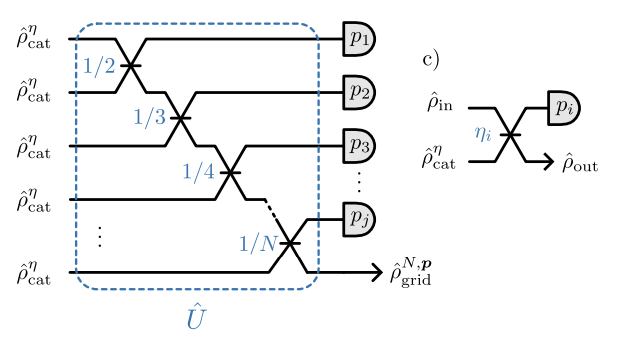

In [1]:
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
from scipy.special import eval_hermite, factorial

First we need to define our squeezed cat states, the beamsplitter operator, the measurement, and finally trace out the measured part of the state, to receive the final grid state:

$| \psi_k \rangle = \hat{S}(r) (| \alpha\rangle + (-1)^k|-\alpha\rangle)$

$\hat{B}(\theta) = \mathrm{exp}\bigg[\frac{i\theta}{\hbar}(\hat{p}_1\hat{x}_2-\hat{x}_1\hat{p}_2) \bigg]  $

P-quadrature operator: $|p\rangle \langle p|$ with $ |p\rangle = [p_1, p_2, ..., p_{N-1}]^T $

And finally the breeding circuit as in the figure above.

In [63]:
# Define the squeezed cat state as a density matrix for input into the circuit
def sq_cat_state(N, k, alpha, r):
    S = qt.squeeze(N, r)
    return S * (qt.coherent(N, alpha) + (-1)**k * qt.coherent(N, -alpha)).unit()

# Define a beamsplitter as an operator and carry out the split on input density matrices
def BS(N, eta, rho1, rho2):
    theta = np.arccos(np.sqrt(eta))

    # Single-mode operators
    a = qt.destroy(N)
    adag = a.dag()
    x_op = (a + adag) / np.sqrt(2)
    p_op = (a - adag) / (1j * np.sqrt(2))
    I = qt.qeye(N)

    # Operators acting on two-mode space
    x1 = qt.tensor(x_op, I)
    x2 = qt.tensor(I, x_op)
    p1 = qt.tensor(p_op, I)
    p2 = qt.tensor(I, p_op)

    U = (1j * theta * (p1 * x2 - x1 * p2)).expm()
    # Create the joint state
    joint_state = qt.tensor(rho1, rho2)
    rho_out = U * joint_state * U.dag()
    return rho_out

# Create the quadrature eigenstate |p = p_val⟩ as a superposition in Fock basis, as it is not included in QuTip.
# We will use this to do a measurement on one of the output modes.
def p_eigenstate(p_val=0.0, N=1):
    # Position-space quadrature eigenstates in Fock basis (using known expression)
    # |p⟩ = sum_n ψ_n(p) |n⟩
    coeffs = []
    for n in range(N):
        Hn = eval_hermite(n, p_val)  # Hermite polynomial H_n(p)
        norm = 1.0 / (np.pi**0.25 * np.sqrt(2.0**n * factorial(n)))
        psi_n = norm * Hn * np.exp(-p_val**2 / 2)
        coeffs.append((1j)**n * psi_n)  # transform to p-basis from x-basis
    return qt.Qobj(coeffs, dims=[[N], [1]]).unit()  # column vector

# Define the measuring function
def p_quad_mode_1(N, p_val, rho_out):
    # Create |p=0⟩
    pket = p_eigenstate(p_val, N=N)

    # Make the projector |p=0⟩⟨p=0|, such that it works on only mode 1
    p_rho = pket * pket.dag()
    P1 = qt.tensor(p_rho, qt.qeye(N))

    # Unnormalized post-measurement state
    rho_post = P1 * rho_out * P1.dag()

    # Probability of measuring p = 0, as is our p_val
    prob = rho_post.tr()

    # Trace out mode 1 to get the conditional state of mode 2
    rho2_post = rho_post.ptrace(1) / prob # Trace out all modes but second mode (read: trace out first mode)
    return rho2_post

# Breeding with n beamsplits, input n amount of etas and n+1 amount of states.
def breeding(N, etas, input_rhos, pvals):
    n = len(etas)
    current = input_rhos[0]
    for i in range(n):
        bs_state = BS(N, etas[0], current, input_rhos[i+1]) # Two modes enter beamsplitter
        post_state2 = p_quad_mode_1(N, pvals[i], bs_state) # Beamsplit mode 1 is measured out
        current = post_state2 # Resulting state
    return current



Now as this code utilizes the $p$-eigenstate, we use an unphysical state, as it contains infite energy, as all modes N are occupied to some vanishing degree, which great for theoritical purposes, but it may be inaccurate when implemented to model real physics. Therefore we take a look at the fock distribution to see for which N the occupancy is sufficiently low. Now the N must not be too high for computational purposes, so we use N=50 as some midway solution. You can also use N = 60 for better results, but takes double the time.

Underneath we take a look at the state for N=155 and N=50 to see how it changes. For N $\rightarrow \infty$ we should have a perfect horisontal line.

C:\Users\alexa\AppData\Local\Temp\ipykernel_1660\3590608080.py:37: RuntimeWarning: overflow encountered in scalar multiply
  norm = 1.0 / (np.pi**0.25 * np.sqrt(2.0**n * factorial(n)))


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

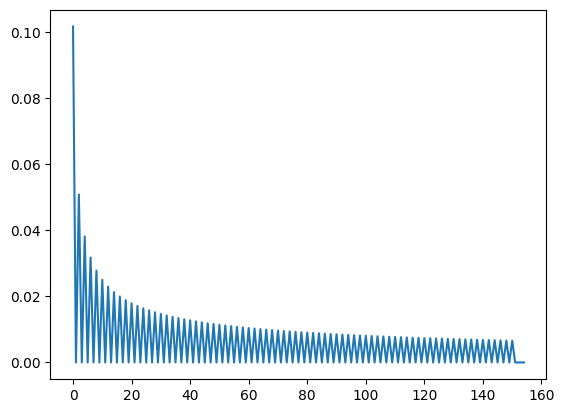

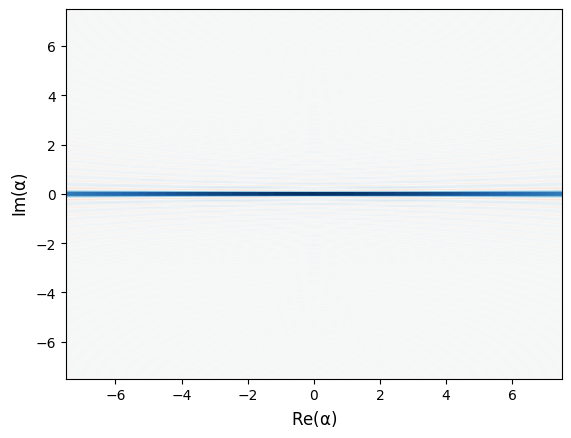

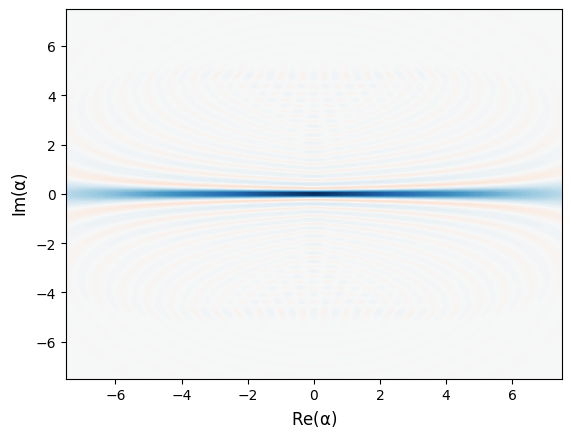

In [77]:
NN = 155
plt.plot((p_eigenstate(0, NN)*p_eigenstate(0, NN).dag()).diag()) # Due to selfmade definition, there must be some numerical limit at ~150
plot_wigner(p_eigenstate(0, 155)*p_eigenstate(0, 155).dag())
plot_wigner(p_eigenstate(0, 50)*p_eigenstate(0, 50).dag())

It seems that N=50 is an okay solution given the plot of the $p$-eigenstate, so we go with that.

Now onto actually producing the grid state after 2 beamsplits and taking a look at the Wigner function of the grid state.

My trial runs say approximately N=40 takes 10sec, N=50 takes 30sec, N=60 takes 1min 15sec, N=100 takes 23min, but N = 50 should be enough, 60 is better, and then it doesnt get much better when you increase N.

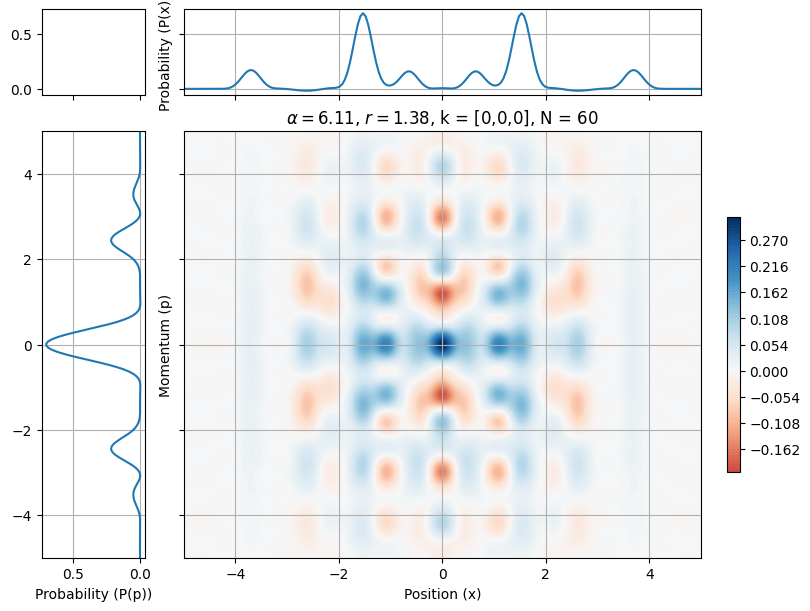

In [78]:
N = 60 # Define N
hbar = 1 # Atomic units, not used in particular
x = np.linspace(-5,5,200) # Define grid
p = np.linspace(-5,5,200)

r = np.log(10**-1.2)/-2 # Define squeezing parameter and alpha from mu as given from article
mu = np.sqrt(3*np.pi/2)
alpha = mu*(1/np.sqrt(2))*np.exp(r)

# Define even and odd squeezed cat states
rho0 = sq_cat_state(N, 0, alpha, r) * sq_cat_state(N, 0, alpha, r).dag()
rho1 = sq_cat_state(N, 1, alpha, r) * sq_cat_state(N, 1, alpha, r).dag()

m = 3 # number of input modes
rhos = [rho0, rho0, rho0] # List of input states, even in the main case of the article
etas = 1 / np.arange(2,m+1) # List of reflectivities of beamsplitters in the breeding circuit
pvals = [0.0, 0.0] # p-quadrature measurement values, 0.0 is standard

# Final grid state
rho_out = breeding(N, etas, rhos, pvals)
W = qt.wigner(rho_out, x, p)

# Probs for plotting
Px = np.trapezoid(W, p, axis=0)  
Pp = np.trapezoid(W, x, axis=1)
vmin = np.min(W)
vmax = np.max(W)
vlim = np.max([np.abs(vmax), np.abs(vmin)])


# Plotting

fig, axs = plt.subplots(
    2, 2,
    figsize=(8, 6),
    constrained_layout=True,
    gridspec_kw={"height_ratios": [0.2, 1], "width_ratios": [0.2, 1]},  # Flip width ratios
    sharex="col", sharey="row"
)


# P(x) plot (still top-left)
axs[0, 1].plot(x, Px)
axs[0, 1].set_ylabel("Probability (P(x))")
axs[0, 1].grid()


axs[0, 1].axis('on')

# Contour plot (now bottom-right)
cf3 = axs[1,1].contourf(x, p, W, levels=100, cmap='RdBu', vmin=-vlim, vmax=vlim)
axs[1,1].set_title(r"$\alpha={:.2f}$, $r = {:.2f}$, k = [0,0,0], N = {}".format(alpha, r, N))
axs[1,1].set_xlabel("Position (x)")
axs[1,1].set_ylabel("Momentum (p)")
axs[1,1].grid()
fig.colorbar(cf3, ax=axs[1,1], location='right', shrink=0.6)

# P(p) plot — now on the left
axs[1,0].plot(Pp, p)
axs[1,0].set_xlabel("Probability (P(p))")
axs[1,0].invert_xaxis()  # optional: flip if you want it to face inwards
axs[1,0].grid()

The picture below is the grid output state for $p_{\mathrm{val}} = 0.0$ from the article. Our state doesnt exactly reflect the grid state from the article, but the tendencies are the same. Both have this vertical line of alternating peaks (blue) and valleys (red) at $x=0$ ($x$ from our state), then at $x \approx\pm 1.6$, we have purely peaks, but there seems to be both peaks and valleys at $x\approx \pm 1.2$, which are just flattened in the grid state from the article. Then again we have a vertical line of peaks and valleys at $x = \pm 2.5$. However, the probability distributions along the axes also follow the tendencies, so its not a terrible result, and the differences are likely due to measuring by projecting onto the unpshyical $| p \rangle$ state and thereby limitations of N.

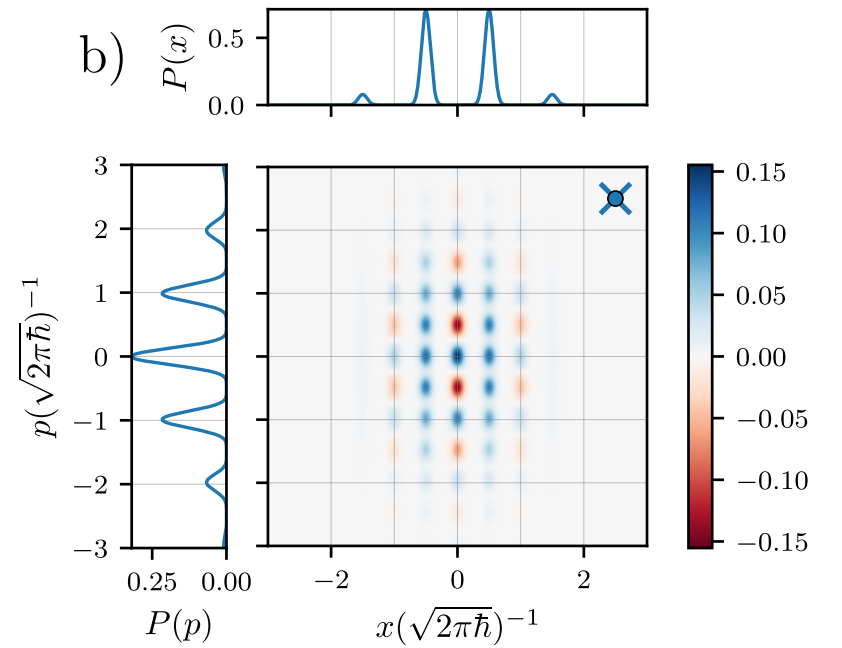